In [1]:
#here we load all the libaries
import pandas as pd
import numpy as np
import math
#https://towardsdatascience.com/accessing-google-spreadsheet-data-using-python-90a5bc214fd2import matplotlib.pyplot as pl
import matplotlib.pyplot as pl

from lmfit import minimize, Parameters
import gspread
from df2gspread import df2gspread as d2g

from oauth2client.service_account import ServiceAccountCredentials
%matplotlib notebook

In [2]:
# second time, because it's necessary for jupyter for whatever reason
%matplotlib notebook

In [3]:
# define the fit (model) function
growth = lambda _t, double_time, initial_value: initial_value * (2**(_t/double_time))

In [4]:
# we define the initial fit function
params = Parameters()
params.add('double_time',value=5,min=1e-3)
params.add('initial_value',value=20,min=1e-3)
# define the residual function (distance between model and data)
def residuals(params, t, data):
    model = growth(t,
                  params['double_time'].value,
                  params['initial_value'].value
                  )
    _residuals = (model-data)**2
    return _residuals


In [5]:
# We load the data from the Corona_Dashboard
scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name('../../../Client_Secret.json', scope)
client = gspread.authorize(creds)
sheet = client.open('Corona_Dashboard_RawData').sheet1
data = sheet.get_all_records()
rawdata=pd.DataFrame(data)
rawdata=rawdata.reset_index().rename(columns={'index': 'days'})
rawdata

,days,Datum,Brandenburg,Berlin
0,0,01.03.2020,0,1
1,1,02.03.2020,1,3
2,2,03.03.2020,1,6
3,3,04.03.2020,1,9
4,4,05.03.2020,1,13
5,5,06.03.2020,2,19
6,6,07.03.2020,2,28
7,7,08.03.2020,4,40
8,8,09.03.2020,7,48
9,9,10.03.2020,16,58


In [6]:
#and then we get rid of all the empty rows
columnlist=[]
rawdata_withoutnan=rawdata
for i in list(rawdata_withoutnan.columns.values):
    if (("day")in i) or (("at")in i):
        print(i)
    else:
        columnlist.append(i)
        rawdata_withoutnan[i]=rawdata_withoutnan[[i]].replace('', np.nan)
rawdata_withoutnan=rawdata_withoutnan.dropna()
rawdata_withoutnan

days
Datum


,days,Datum,Brandenburg,Berlin
0,0,01.03.2020,0.0,1.0
1,1,02.03.2020,1.0,3.0
2,2,03.03.2020,1.0,6.0
3,3,04.03.2020,1.0,9.0
4,4,05.03.2020,1.0,13.0
5,5,06.03.2020,2.0,19.0
6,6,07.03.2020,2.0,28.0
7,7,08.03.2020,4.0,40.0
8,8,09.03.2020,7.0,48.0
9,9,10.03.2020,16.0,58.0


<IPython.core.display.Javascript object>


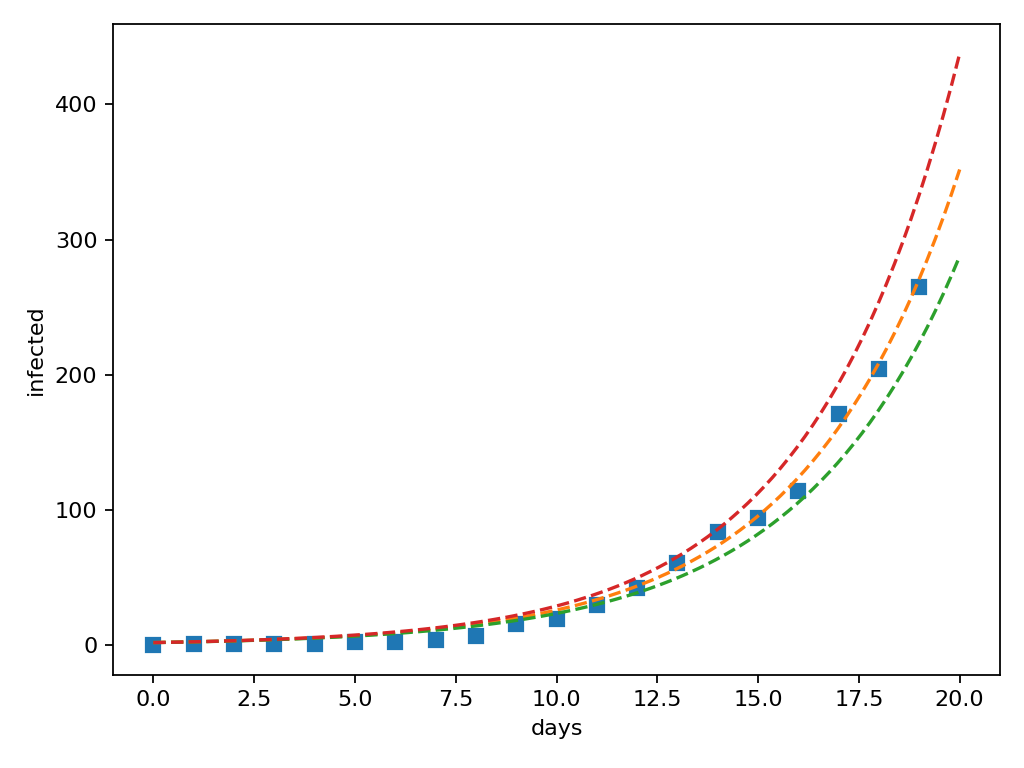

              Obere Schätzung  Mittlere Schätzung  Untere Schätzung
Aktuell                   2.8                 2.7               2.5
Vor 3 Tagen               2.9                 2.7               2.4
Letzte Woche              2.4                 2.3               2.2


<IPython.core.display.Javascript object>


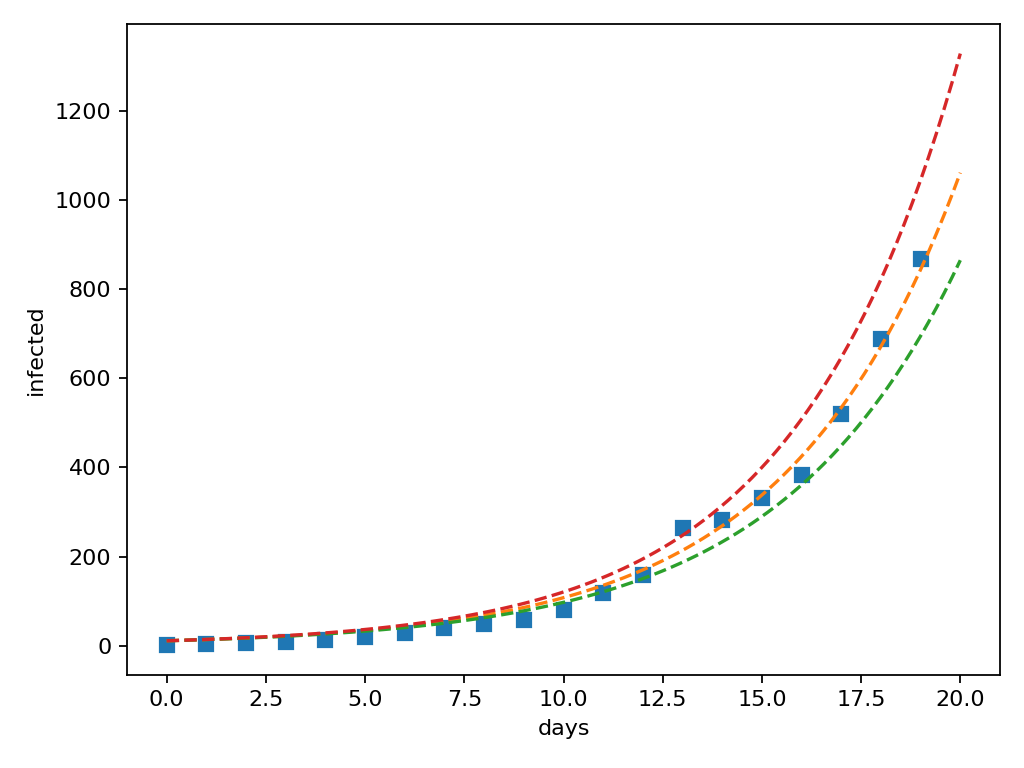

              Obere Schätzung  Mittlere Schätzung  Untere Schätzung
Aktuell                   3.2                 3.0               2.8
Vor 3 Tagen               3.5                 3.2               2.8
Letzte Woche              2.4                 2.3               2.2


In [7]:
#then for each federalstate
for i in columnlist:
    #we take the series of infected and the series of days
    infected=rawdata_withoutnan[i]
    t=rawdata_withoutnan["days"]
    # perform the fit 
    out = minimize(residuals,params,args=(t, infected, ),)
    # get the best fit parameters with errors
    bestparams = out.params
    # plot
    tt = np.linspace(0,len(rawdata_withoutnan),100)
    model = growth(tt,
                   bestparams['double_time'].value,
                   bestparams['initial_value'].value)
    pl.figure()
    pl.plot(t,infected,'s')
    pl.plot(tt,model,'--')
    
    
    # use the double standard deviation confidence (95% confidence)
    doubletimeerr = 2*bestparams['double_time'].stderr
    
    #and also plot the low estimate and high estimate of cases
    model_low = growth(tt,
                   bestparams['double_time'].value + doubletimeerr,
                   bestparams['initial_value'].value)
    model_high = growth(tt,
                   bestparams['double_time'].value - doubletimeerr,
                   bestparams['initial_value'].value)
    pl.plot(tt,model_low,'--')
    pl.plot(tt,model_high,'--')

    pl.xlabel('days')
    pl.ylabel('infected')
    pl.gcf().tight_layout()
    
    #then we do the same for what the state of play was 3 days ago, if we have more than 8 data points
    if (len(rawdata_withoutnan[:-3])>8):
        infected_3=rawdata_withoutnan[i][:-3]
        t_3=rawdata_withoutnan["days"][:-3]

        # perform the fit 
        out_3 = minimize(residuals,params,args=(t_3, infected_3, ),)
        # get the best fit parameters with errors
        bestparams_3 = out_3.params
        bestparams_3
    #then we do the same for what the state of play was 7 days ago, if we have more than 8 data points

    if (len(rawdata_withoutnan[:-7])>8):
        infected_7=rawdata_withoutnan["Berlin"][:-7]
        t_7=rawdata_withoutnan["days"][:-7]

        # perform the fit 
        out_7 = minimize(residuals,params,args=(t_7, infected_7, ),)
        # get the best fit parameters with errors
        bestparams_7 = out_7.params
        bestparams_7
    #then we write the results into a dictionary with two standard errors on top and bottom as padding
    dict_calc={}
    dict_calc["Obere Schätzung"]=[bestparams['double_time'].value+2*bestparams['double_time'].stderr,
                        bestparams_3['double_time'].value+2*bestparams_3['double_time'].stderr,
                        bestparams_7['double_time'].value+2*bestparams_7['double_time'].stderr]
    dict_calc["Mittlere Schätzung"]=[bestparams['double_time'].value,bestparams_3['double_time'].value,bestparams_7['double_time'].value]

    dict_calc["Untere Schätzung"]=[bestparams['double_time'].value-2*bestparams['double_time'].stderr,
                        bestparams_3['double_time'].value-2*bestparams_3['double_time'].stderr,
                        bestparams_7['double_time'].value-2*bestparams_7['double_time'].stderr]
    doubletimedf=pd.DataFrame(dict_calc,index=['Aktuell', 'Vor 3 Tagen', 'Letzte Woche'])
    #we round downwards for the lower estimates and upwards for the upper estimate and round for the middle one
    doubletimedf["Untere Schätzung"]=np.floor(doubletimedf["Untere Schätzung"]*10)/10
    doubletimedf["Mittlere Schätzung"]=np.round(doubletimedf["Mittlere Schätzung"]*10)/10
    doubletimedf["Obere Schätzung"]=np.ceil(doubletimedf["Obere Schätzung"]*10)/10
    
    #and send this results sheet to google
    #doubletimedf=(doubletimedf.transpose())
    print(doubletimedf)
    spreadsheet_key = ''
    wks_name = i
    d2g.upload(doubletimedf, spreadsheet_key, wks_name, credentials=creds, row_names=True)

    

In [24]:
doubletimedf.index.names = ['Maß']
doubletimedf

,Obere Schätzung,Mittlere Schätzung,Untere Schätzung
Maß,,,
Aktuell,3.3,3.1,2.8
Vor 3 Tagen,3.2,2.9,2.5
Letzte Woche,2.5,2.3,2.1
